In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

from skimage.io import imread
from scipy.signal import convolve2d

from scipy.stats import cauchy, norm #chi2, erlang, expon, genexpon, ncx2, poisson, powerlaw, rayleigh

In [2]:
#image_list = glob('/home/pvt/Workspace/multibeam-classification/dataset-1/*raw.png') # window set to 2.25m to 11.25m
# image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/2016-07-19.11/0047/*raw.png') # window set to 2.25m to 11.25m
image_list = glob('/home/pvt/Workspace/Data/HAUV/DIDSON/2016-07-19.11/0102/*raw.png') # window set to 2.25m to 11.25m
print len(image_list)

import cv2
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('data/DIDSON/didson.json')

98
Resolution
Desired: 0.02 , x: 0.0199847165996 , y: 0.0200030206842
Resolution
Desired: 0.02 , x: 0.0199794887389 , y: 0.01998400879


image: 4
0.0 0.921568627451
(512, 96)


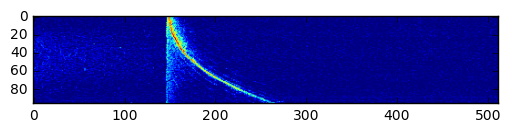

In [3]:
idx = np.random.randint(0,len(image_list))
# idx=30950
# idx = 32962
# idx=36944 #- sparse fish
# idx=40891 #- reverb
# idx = 35552

print 'image:',idx
# img = imread(image_list[idx], as_grey=True)
ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE)
img = didson.deconvolve(ping)
# img = ping
img = img.astype(np.float64)/255.0
print np.amin(img), np.amax(img)
print img.shape
plt.imshow(ping.transpose())

u0: 0.437291206154 - 4.40639723754
u1: 0.00528859799284 - 1.97288726809
s: 125.0
u0: 0.437291206154 - 4.40639723754
u1: 0.00528859799284 - 1.99999992167
s: 62.5
changes: 0
iterations: 2
[147 146 146 146 146 146 146 146 146 147 147 146 147 147 148 148 147 147
 148 148 149 149 149 149 150 151 151 153 153 153 153 153 154 154 154 155
 155 155 156 156 157 158 158 159 160 160 160 162 163 164 165 165 166 168
 168 169 171 171 172 173 174 175 176 177 179 180 180 181 183 184 185 186
 189 191 192 193 196 196 198 199 201 202 204 205 208 209 211 212 214 215
 217 218 219 220 222 224]
[-1  0  0  0  0  0  0  0  1  0 -1  1  0  1  0 -1  0  1  0  1  0  0  0  1  1
  0  2  0  0  0  0  1  0  0  1  0  0  1  0  1  1  0  1  1  0  0  2  1  1  1
  0  1  2  0  1  2  0  1  1  1  1  1  1  2  1  0  1  2  1  1  1  3  2  1  1
  3  0  2  1  2  1  2  1  3  1  2  1  2  1  2  1  1  1  2  2]


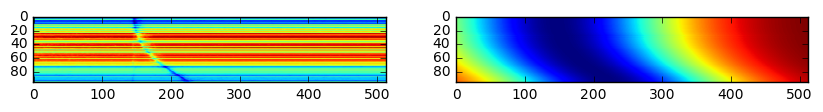

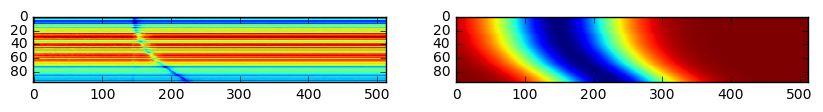

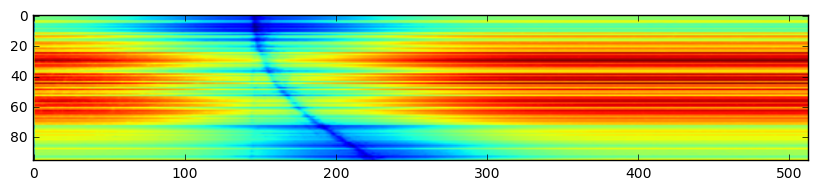

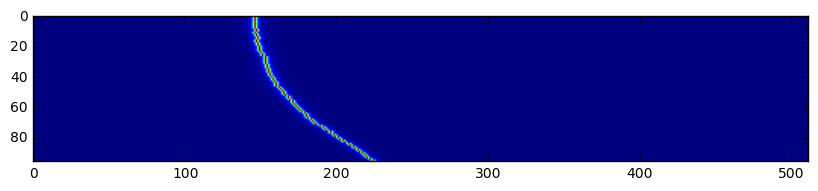

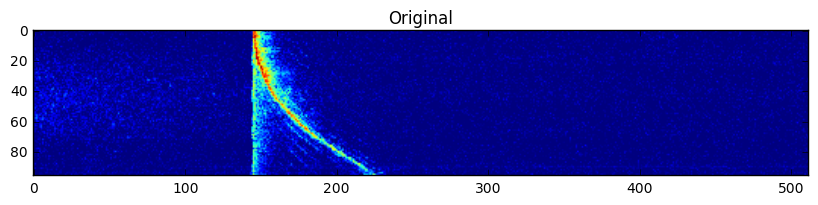

In [22]:
# %%timeit

"""
Tunable parameters:
- Cauchy scale
- Transition cost & cooling
- relative weight (u0/u1)
- 1st-order void-label cost

To Do:
- better edge handling on roll 
- handle "void" labels on transition cost (should get replaced by fixed cost!)
- try other transition weights (not just normal) - e.g. triangular, parabolic, square window
- speed up computation (need <0.1/loop)
- track empirical pdf for transition
"""
# c_scale = 0.33
c_scale = 1
void_cost = .5 # transition cost
w1 = 1

# get a prior on the labels
midx = np.argmax(img, axis=0) # return max location per row
midx.shape = (1,96)

# pre-allocate vector used to evaluate Cauchy functions
x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
    
# compute 0-order label cost map 
u0 = np.zeros_like(x)
    
# one for each range assignment (this is taking most of the time (>2s))
for i in range(0,512):
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)
    
# 'void' label
u0v = np.sum(np.square(img),axis=0) 
u0 = np.vstack((u0v,u0))
# u0/=u0.max() # range 0-1

s = 250

i = 0
while True:
    i = i+1
    
    a = np.tile(midx,(512,1))
    l = np.roll(a,1,axis=1)
    l[:,0]=l[:,1]
#     ll = np.roll(l,1, axis=1)
#     ll[:,0]=ll[:,1]
    r = np.roll(a,-1,axis=1)
    r[:,-1] = r[:,-2]
#     rr = np.roll(r,-1, axis=1)
#     rr[:,-1] = rr[:,-2]  

    s = 0.5*s;
    u1 = 2 - 2.5*s*norm.pdf((l-x),loc=0, scale=s ) - 2.5*s*norm.pdf((r-x),loc=0, scale=s )
#     u1 = 4 - 2.5*s*norm.pdf((l-x),loc=0, scale=s ) - 2.5*s*norm.pdf((r-x),loc=0, scale=s ) - 2.5*s*norm.pdf((ll-x),loc=0, scale=s ) - 2.5*s*norm.pdf((rr-x),loc=0, scale=s )
#     u1 = 4 - 2.5*s*np.absolute(l-x) - 2.5*s*np.absolute(r-x) - 2.5*s*np.absolute(ll-x) - 2.5*s*np.absolute(rr-x)
    u1 = np.vstack((void_cost*np.ones_like(u0v),u1))
#     u1/=u1.max()
    
    print 'u0:',np.amin(u0),'-',np.amax(u0)
    print 'u1:',np.amin(u1),'-',np.amax(u1)
    print 's:',s
#     cost = u0/np.amax(u0) + u1/np.amax(u1)
    cost = u0 + u1
    
    midx_new = np.argmin(cost, axis=0)
    changes = np.sum((midx-midx_new)!=0)
    midx = midx_new
    
    plt.figure(figsize=(10,4))
#     plt.imshow((cost).transpose())
    plt.subplot(1,2,1)
    plt.imshow(u0.transpose())
    plt.subplot(1,2,2)
    plt.imshow(u1.transpose())
    
    if s<5:
        break
    
    if changes<=0:
        break
        
    if i>10:
        break

print 'changes:', changes
        
print 'iterations:',i
plt.figure(figsize=(10,4))
plt.imshow(cost.transpose())
        
simg = cauchy.pdf(x,loc=midx, scale=c_scale)
plt.figure(figsize=(10,4))
plt.imshow(simg.transpose())

plt.figure(figsize=(10,4))
plt.imshow(ping.transpose())
plt.title('Original') 

print midx
print np.diff(midx)

5.8730409992354762

In [7]:
# %%timeit

c_scale = 2.0

# empty beams will square-integrate to < 0.1
# beams with returns will integrate to > 0.2
# plt.plot(np.sum(np.square(img),axis=0))

# for i in range(0, 512):
#     u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)

i=range(0,512)
u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)

    
a = cauchy.pdf(x, loc = x, scale =c_scale)
# print a.shape

plt.figure()
plt.imshow(u0.transpose())
plt.figure()
plt.imshow(a.transpose())

TypeError: can only concatenate list (not "float") to list

In [108]:
plt.figure(figsize=(10,10))
plt.imshow(img.transpose())

x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
plt.figure(figsize=(10,10))
plt.imshow(x.transpose())

for i in range(0, 512):
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)

plt.figure(figsize=(10,10))
plt.imshow(u0.transpose())
    
# midx = np.argmax(img, axis=0) # return max location per row
# midx.shape = (1,96)
# print x.shape
# xv = x
# xv.shape =(512,96,1)
# xv = np.tile(x,(1,1,512))
# print xv.shape
# a = cauchy.pdf(xv, loc=x, scale = c_scale)
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)
# print a.shape

IndentationError: unexpected indent (<ipython-input-108-40e13ac92ee7>, line 24)

In [10]:
# %%timeit
c_scale = 0.33
x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
xl = [x] * 512
ml = np.split(x, 512,axis=0)
# print len(ml)
# print ml
print ml[1]
print len(ml)
print x

# u0.shape
# u0 = np.sum(np.square(img - cauchy.pdf(xv, loc=x, scale = c_scale)),axis=0)
# print u0.shape
# plt.imshow(u0[:,:,100].transpose())

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.]]
512
[[   0.    0.    0. ...,    0.    0.    0.]
 [   1.    1.    1. ...,    1.    1.    1.]
 [   2.    2.    2. ...,    2.    2.    2.]
 ..., 
 [ 509.  509.  509. ...,  509.  509.  509.]
 [ 510.  510.  510. ...,  510.  510.  510.]
 [ 511.  511.  511. ...,  511.  511.  511.]]


In [11]:
%%timeit
# print len(xl), len(ml)
# print xl[100]
# print ml[100]

# print type(xl)
# print type(xl[0])
# print type(ml)
# print type(ml[0])
# cl = np.asarray(ml)
# print type(cl)

# this works...
# u0 = cauchy.pdf(xl[100], loc=ml[100], scale = c_scale) 
# plt.imshow(u0.transpose())
# ...but this doesn't
# u0 = cauchy.pdf(xl[100:200], loc=ml[100:200], scale = c_scale) 
# plt.imshow(u0[50].transpose())
# ...and neither does this

# plt.imshow(u0[100].transpose())
# print len(u0)
# print u0[0].shape

# BEGIN
u0 = cauchy.pdf(xl, loc=ml, scale = c_scale) 
il = [img]*512
v0 = np.square(u0-il)
v0s = np.sum(v0,axis=1)
v0i = np.array(v0s)
# END

# print len(v0)
# print v0[0].shape

# print len(v0s)
# print v0s[0].shape

# print v0i.shape
# plt.figure()
# plt.imshow(v0i.transpose())
# v = np.array(v0)
# print v.shape
# plt.figure(figsize=(10,10))
# j = 70
# plt.imshow(u0[j].transpose())
# print np.amin(u0[j]), np.amax(u0[j])


u0 = np.zeros_like(x)
    
# one for each range assignment
# this is taking most of the time (>2s)
# for i in range(0,512):
#     u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)
    
# plt.figure()
# plt.imshow(u0.transpose())

1 loop, best of 3: 3.85 s per loop
